### COMPARAÇÃO DE MODELOS DE REDES NEURAIS
### ANN, MLP, CNN, RNN, GRU, LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import time
import warnings
warnings.filterwarnings('ignore')

### FUNÇÕES DE ATIVAÇÃO E UTILITÁRIOS

In [2]:
def sigmoid(x):
    """Função Sigmóide"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x):
    """Derivada da função sigmóide"""
    return x * (1 - x)

def relu(x):
    """Função ReLU"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivada da função ReLU"""
    return (x > 0).astype(float)

def tanh(x):
    """Função Tanh"""
    return np.tanh(x)

def tanh_derivative(x):
    """Derivada da função Tanh"""
    return 1 - x**2

def softmax(x):
    """Função Softmax"""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### CLASSE BASE PARA REDES NEURAIS

In [3]:
class BaseNeuralNetwork:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.loss_history = []
        self.model_name = "Base"
        
    def compute_loss(self, y_true, y_pred):
        """Calcula o erro usando Mean Squared Error"""
        m = y_true.shape[0]
        loss = np.sum((y_true - y_pred) ** 2) / (2 * m)
        return loss
    
    def train(self, X, y, epochs=1000, verbose=True):
        """Método de treinamento base"""
        print(f"\n[{self.model_name}] Iniciando treinamento por {epochs} épocas...")
        start_time = time.time()
        
        for epoch in range(epochs):
            # Forward propagation
            y_pred = self.forward_propagation(X)
            
            # Cálculo do erro
            loss = self.compute_loss(y, y_pred)
            self.loss_history.append(loss)
            
            # Backward propagation
            self.backward_propagation(X, y, y_pred)
            
            # Exibir progresso
            if verbose and epoch % 200 == 0:
                print(f"[{self.model_name}] Época {epoch:4d} | Erro: {loss:.6f}")
        
        training_time = time.time() - start_time
        print(f"[{self.model_name}] Treinamento concluído! Erro final: {loss:.6f}")
        print(f"[{self.model_name}] Tempo de treinamento: {training_time:.2f}s")
        return training_time

### 1. REDE NEURAL ARTIFICIAL SIMPLES (ANN)

In [4]:
class SimpleANN(BaseNeuralNetwork):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        super().__init__(learning_rate)
        self.model_name = "ANN"
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Inicialização dos pesos
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.5
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.5
        self.b2 = np.zeros((1, self.output_size))
    
    def forward_propagation(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2
    
    def backward_propagation(self, X, y, y_pred):
        m = X.shape[0]
        
        # Gradientes da camada de saída
        dz2 = (y_pred - y) * sigmoid_derivative(self.a2)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Gradientes da camada oculta
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        # Atualização dos pesos
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

### 2. PERCEPTRON MULTICAMADAS (MLP)

In [5]:
class MLP(BaseNeuralNetwork):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        super().__init__(learning_rate)
        self.model_name = "MLP"
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Criando as camadas
        self.layers = []
        prev_size = input_size
        
        # Camadas ocultas
        for hidden_size in hidden_sizes:
            self.layers.append({
                'W': np.random.randn(prev_size, hidden_size) * 0.5,
                'b': np.zeros((1, hidden_size))
            })
            prev_size = hidden_size
        
        # Camada de saída
        self.layers.append({
            'W': np.random.randn(prev_size, output_size) * 0.5,
            'b': np.zeros((1, output_size))
        })
        
        # Para armazenar ativações
        self.activations = []
        self.z_values = []
    
    def forward_propagation(self, X):
        self.activations = [X]
        self.z_values = []
        
        current_input = X
        
        for i, layer in enumerate(self.layers):
            z = np.dot(current_input, layer['W']) + layer['b']
            self.z_values.append(z)
            
            # Função de ativação (ReLU para camadas ocultas, Sigmoid para saída)
            if i < len(self.layers) - 1:
                a = relu(z)
            else:
                a = sigmoid(z)
            
            self.activations.append(a)
            current_input = a
        
        return self.activations[-1]
    
    def backward_propagation(self, X, y, y_pred):
        m = X.shape[0]
        
        # Gradiente da camada de saída
        dz = (y_pred - y) * sigmoid_derivative(self.activations[-1])
        
        # Propagação reversa
        for i in range(len(self.layers) - 1, -1, -1):
            # Gradientes dos pesos e bias
            dW = np.dot(self.activations[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            
            # Atualização
            self.layers[i]['W'] -= self.learning_rate * dW
            self.layers[i]['b'] -= self.learning_rate * db
            
            # Gradiente para a próxima camada
            if i > 0:
                da = np.dot(dz, self.layers[i]['W'].T)
                dz = da * relu_derivative(self.activations[i])
    
    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

### 3. REDE NEURAL CONVOLUCIONAL SIMPLES (CNN)

In [6]:
class SimpleCNN(BaseNeuralNetwork):
    def __init__(self, input_shape, num_filters, filter_size, output_size, learning_rate=0.01):
        super().__init__(learning_rate)
        self.model_name = "CNN"
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.output_size = output_size
        
        # Filtros convolucionais
        self.filters = np.random.randn(num_filters, filter_size, filter_size) * 0.1
        
        # Camada totalmente conectada
        conv_output_size = (input_shape[0] - filter_size + 1) * (input_shape[1] - filter_size + 1) * num_filters
        self.W_fc = np.random.randn(conv_output_size, output_size) * 0.5
        self.b_fc = np.zeros((1, output_size))
    
    def convolve(self, image, filter_):
        """Operação de convolução"""
        h, w = image.shape
        fh, fw = filter_.shape
        result = np.zeros((h - fh + 1, w - fw + 1))
        
        for i in range(h - fh + 1):
            for j in range(w - fw + 1):
                result[i, j] = np.sum(image[i:i+fh, j:j+fw] * filter_)
        
        return result
    
    def forward_propagation(self, X):
        batch_size = X.shape[0]
        conv_outputs = []
        
        # Assumindo que X tem shape (batch_size, height, width)
        for i in range(batch_size):
            sample_output = []
            for f in range(self.num_filters):
                conv_result = self.convolve(X[i], self.filters[f])
                sample_output.append(conv_result.flatten())
            conv_outputs.append(np.concatenate(sample_output))
        
        self.conv_output = np.array(conv_outputs)
        
        # Camada totalmente conectada
        self.z_fc = np.dot(self.conv_output, self.W_fc) + self.b_fc
        self.a_fc = sigmoid(self.z_fc)
        
        return self.a_fc
    
    def backward_propagation(self, X, y, y_pred):
        m = X.shape[0]
        
        # Gradientes da camada totalmente conectada
        dz_fc = (y_pred - y) * sigmoid_derivative(self.a_fc)
        dW_fc = np.dot(self.conv_output.T, dz_fc) / m
        db_fc = np.sum(dz_fc, axis=0, keepdims=True) / m
        
        # Atualização (simplificada)
        self.W_fc -= self.learning_rate * dW_fc
        self.b_fc -= self.learning_rate * db_fc
        
        # Nota: Gradientes dos filtros seriam mais complexos de implementar
        # Para simplicidade, apenas atualizamos a camada FC
    
    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

### 4. REDE NEURAL RECORRENTE (RNN)

In [7]:
class SimpleRNN(BaseNeuralNetwork):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        super().__init__(learning_rate)
        self.model_name = "RNN"
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Pesos
        self.Wxh = np.random.randn(input_size, hidden_size) * 0.5
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.5
        self.Why = np.random.randn(hidden_size, output_size) * 0.5
        self.bh = np.zeros((1, hidden_size))
        self.by = np.zeros((1, output_size))
    
    def forward_propagation(self, X):
        batch_size, seq_len, _ = X.shape
        
        # Inicializar estado oculto
        h = np.zeros((batch_size, self.hidden_size))
        self.hidden_states = []
        
        # Processar sequência
        for t in range(seq_len):
            h = tanh(np.dot(X[:, t, :], self.Wxh) + np.dot(h, self.Whh) + self.bh)
            self.hidden_states.append(h.copy())
        
        # Saída final
        output = sigmoid(np.dot(h, self.Why) + self.by)
        return output
    
    def backward_propagation(self, X, y, y_pred):
        # Implementação simplificada
        m = X.shape[0]
        
        # Gradiente da saída
        dWhy = np.dot(self.hidden_states[-1].T, (y_pred - y)) / m
        dby = np.sum(y_pred - y, axis=0, keepdims=True) / m
        
        # Atualização (simplificada)
        self.Why -= self.learning_rate * dWhy
        self.by -= self.learning_rate * dby
    
    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

### 5. GATED RECURRENT UNIT (GRU)

In [8]:
class SimpleGRU(BaseNeuralNetwork):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        super().__init__(learning_rate)
        self.model_name = "GRU"
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Pesos para reset gate
        self.Wxr = np.random.randn(input_size, hidden_size) * 0.5
        self.Whr = np.random.randn(hidden_size, hidden_size) * 0.5
        self.br = np.zeros((1, hidden_size))
        
        # Pesos para update gate
        self.Wxz = np.random.randn(input_size, hidden_size) * 0.5
        self.Whz = np.random.randn(hidden_size, hidden_size) * 0.5
        self.bz = np.zeros((1, hidden_size))
        
        # Pesos para candidato
        self.Wxh = np.random.randn(input_size, hidden_size) * 0.5
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.5
        self.bh = np.zeros((1, hidden_size))
        
        # Pesos para saída
        self.Why = np.random.randn(hidden_size, output_size) * 0.5
        self.by = np.zeros((1, output_size))
    
    def forward_propagation(self, X):
        batch_size, seq_len, _ = X.shape
        h = np.zeros((batch_size, self.hidden_size))
        
        for t in range(seq_len):
            x_t = X[:, t, :]
            
            # Reset gate
            r_t = sigmoid(np.dot(x_t, self.Wxr) + np.dot(h, self.Whr) + self.br)
            
            # Update gate
            z_t = sigmoid(np.dot(x_t, self.Wxz) + np.dot(h, self.Whz) + self.bz)
            
            # Candidato
            h_tilde = tanh(np.dot(x_t, self.Wxh) + np.dot(r_t * h, self.Whh) + self.bh)
            
            # Novo estado oculto
            h = (1 - z_t) * h + z_t * h_tilde
        
        # Saída
        output = sigmoid(np.dot(h, self.Why) + self.by)
        return output
    
    def backward_propagation(self, X, y, y_pred):
        # Implementação simplificada
        m = X.shape[0]
        dWhy = np.dot(h.T, (y_pred - y)) / m
        dby = np.sum(y_pred - y, axis=0, keepdims=True) / m
        
        self.Why -= self.learning_rate * dWhy
        self.by -= self.learning_rate * dby
    
    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

### 6. LONG SHORT-TERM MEMORY (LSTM)

In [9]:
class SimpleLSTM(BaseNeuralNetwork):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        super().__init__(learning_rate)
        self.model_name = "LSTM"
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Pesos para forget gate
        self.Wxf = np.random.randn(input_size, hidden_size) * 0.5
        self.Whf = np.random.randn(hidden_size, hidden_size) * 0.5
        self.bf = np.zeros((1, hidden_size))
        
        # Pesos para input gate
        self.Wxi = np.random.randn(input_size, hidden_size) * 0.5
        self.Whi = np.random.randn(hidden_size, hidden_size) * 0.5
        self.bi = np.zeros((1, hidden_size))
        
        # Pesos para candidato
        self.Wxc = np.random.randn(input_size, hidden_size) * 0.5
        self.Whc = np.random.randn(hidden_size, hidden_size) * 0.5
        self.bc = np.zeros((1, hidden_size))
        
        # Pesos para output gate
        self.Wxo = np.random.randn(input_size, hidden_size) * 0.5
        self.Who = np.random.randn(hidden_size, hidden_size) * 0.5
        self.bo = np.zeros((1, hidden_size))
        
        # Pesos para saída
        self.Why = np.random.randn(hidden_size, output_size) * 0.5
        self.by = np.zeros((1, output_size))
    
    def forward_propagation(self, X):
        batch_size, seq_len, _ = X.shape
        h = np.zeros((batch_size, self.hidden_size))
        c = np.zeros((batch_size, self.hidden_size))
        
        for t in range(seq_len):
            x_t = X[:, t, :]
            
            # Forget gate
            f_t = sigmoid(np.dot(x_t, self.Wxf) + np.dot(h, self.Whf) + self.bf)
            
            # Input gate
            i_t = sigmoid(np.dot(x_t, self.Wxi) + np.dot(h, self.Whi) + self.bi)
            
            # Candidato
            c_tilde = tanh(np.dot(x_t, self.Wxc) + np.dot(h, self.Whc) + self.bc)
            
            # Cell state
            c = f_t * c + i_t * c_tilde
            
            # Output gate
            o_t = sigmoid(np.dot(x_t, self.Wxo) + np.dot(h, self.Who) + self.bo)
            
            # Hidden state
            h = o_t * tanh(c)
        
        # Saída
        output = sigmoid(np.dot(h, self.Why) + self.by)
        return output
    
    def backward_propagation(self, X, y, y_pred):
        # Implementação simplificada
        m = X.shape[0]
        dWhy = np.dot(h.T, (y_pred - y)) / m
        dby = np.sum(y_pred - y, axis=0, keepdims=True) / m
        
        self.Why -= self.learning_rate * dWhy
        self.by -= self.learning_rate * dby
    
    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

### FUNÇÃO PRINCIPAL DE COMPARAÇÃO

In [10]:
def compare_neural_networks():
    print("="*80)
    print("COMPARAÇÃO DE MODELOS DE REDES NEURAIS")
    print("="*80)
    
    # Preparação dos dados
    print("\n1. PREPARAÇÃO DOS DADOS")
    print("-" * 40)
    
    # Dados para classificação (ANN, MLP)
    X_class, y_class = make_classification(
        n_samples=1000, n_features=10, n_informative=5, 
        n_redundant=2, n_clusters_per_class=1, random_state=42
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Dados para CNNs (imagens 2D simuladas)
    X_cnn = np.random.randn(200, 8, 8)  # 200 imagens 8x8
    y_cnn = np.random.randint(0, 2, (200, 1))
    
    # Dados para RNNs (sequências temporais)
    X_rnn = np.random.randn(200, 5, 4)  # 200 sequências de 5 timesteps com 4 features
    y_rnn = np.random.randint(0, 2, (200, 1))
    
    print(f"Dados de classificação: {X_train_scaled.shape}")
    print(f"Dados para CNN: {X_cnn.shape}")
    print(f"Dados para RNN: {X_rnn.shape}")
    
    # Resultados
    results = {}
    
    # 2. TESTANDO MODELOS
    print("\n2. TESTANDO MODELOS")
    print("-" * 40)
    
    try:
        # ANN
        print("\n[1/6] Testando ANN...")
        ann = SimpleANN(X_train_scaled.shape[1], 8, 1, learning_rate=0.1)
        train_time = ann.train(X_train_scaled, y_train.reshape(-1, 1), epochs=500, verbose=False)
        y_pred = ann.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred.flatten())
        results['ANN'] = {'accuracy': accuracy, 'time': train_time, 'loss': ann.loss_history[-1]}
        
        # MLP
        print("\n[2/6] Testando MLP...")
        mlp = MLP(X_train_scaled.shape[1], [16, 8], 1, learning_rate=0.1)
        train_time = mlp.train(X_train_scaled, y_train.reshape(-1, 1), epochs=500, verbose=False)
        y_pred = mlp.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred.flatten())
        results['MLP'] = {'accuracy': accuracy, 'time': train_time, 'loss': mlp.loss_history[-1]}
        
        # CNN
        print("\n[3/6] Testando CNN...")
        cnn = SimpleCNN((8, 8), 4, 3, 1, learning_rate=0.1)
        train_time = cnn.train(X_cnn[:160], y_cnn[:160], epochs=300, verbose=False)
        y_pred = cnn.predict(X_cnn[160:])
        accuracy = accuracy_score(y_cnn[160:], y_pred.flatten())
        results['CNN'] = {'accuracy': accuracy, 'time': train_time, 'loss': cnn.loss_history[-1]}
        
        # RNN
        print("\n[4/6] Testando RNN...")
        rnn = SimpleRNN(4, 8, 1, learning_rate=0.1)
        train_time = rnn.train(X_rnn[:160], y_rnn[:160], epochs=300, verbose=False)
        y_pred = rnn.predict(X_rnn[160:])
        accuracy = accuracy_score(y_rnn[160:], y_pred.flatten())
        results['RNN'] = {'accuracy': accuracy, 'time': train_time, 'loss': rnn.loss_history[-1]}
        
        # GRU
        print("\n[5/6] Testando GRU...")
        gru = SimpleGRU(4, 8, 1, learning_rate=0.1)
        train_time = gru.train(X_rnn[:160], y_rnn[:160], epochs=300, verbose=False)
        y_pred = gru.predict(X_rnn[160:])
        accuracy = accuracy_score(y_rnn[160:], y_pred.flatten())
        results['GRU'] = {'accuracy': accuracy, 'time': train_time, 'loss': gru.loss_history[-1]}
        
        # LSTM
        print("\n[6/6] Testando LSTM...")
        lstm = SimpleLSTM(4, 8, 1, learning_rate=0.1)
        train_time = lstm.train(X_rnn[:160], y_rnn[:160], epochs=300, verbose=False)
        y_pred = lstm.predict(X_rnn[160:])
        accuracy = accuracy_score(y_rnn[160:], y_pred.flatten())
        results['LSTM'] = {'accuracy': accuracy, 'time': train_time, 'loss': lstm.loss_history[-1]}
        
    except Exception as e:
        print(f"Erro durante o treinamento: {e}")
    
    # 3. RESULTADOS COMPARATIVOS
    print("\n3. RESULTADOS COMPARATIVOS")
    print("-" * 40)
    
    if results:
        print(f"{'Modelo':<10} {'Acurácia':<10} {'Tempo (s)':<10} {'Erro Final':<12}")
        print("-" * 45)
        
        for model, metrics in results.items():
            print(f"{model:<10} {metrics['accuracy']:<10.4f} {metrics['time']:<10.2f} {metrics['loss']:<12.6f}")
    
    # 4. VISUALIZAÇÃO
    print("\n4. VISUALIZAÇÃO DOS RESULTADOS")
    print("-" * 40)
    
    if results:
        # Plotar comparação
        models = list(results.keys())
        accuracies = [results[m]['accuracy'] for m in models]
        times = [results[m]['time'] for m in models]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Gráfico de acurácia
        ax1.bar(models, accuracies, color=['blue', 'green', 'red', 'orange', 'purple', 'brown'])
        ax1.set_title('Acurácia por Modelo')
        ax1.set_ylabel('Acurácia')
        ax1.set_ylim(0, 1)
        
        # Gráfico de tempo
        ax2.bar(models, times, color=['blue', 'green', 'red', 'orange', 'purple', 'brown'])
        ax2.set_title('Tempo de Treinamento por Modelo')
        ax2.set_ylabel('Tempo (segundos)')
        
        plt.tight_layout()
        plt.show()
    
    # 5. ANÁLISE COMPARATIVA
    print("\n5. ANÁLISE COMPARATIVA")
    print("-" * 40)
    
    print("\n📊 CARACTERÍSTICAS DOS MODELOS:")
    print("\n• ANN (Artificial Neural Network):")
    print("  - Modelo mais simples")
    print("  - Boa para problemas básicos de classificação")
    print("  - Rápido para treinar")
    
    print("\n• MLP (Multi-Layer Perceptron):")
    print("  - Múltiplas camadas ocultas")
    print("  - Melhor capacidade de aproximação")
    print("  - Versátil para diversos problemas")
    
    print("\n• CNN (Convolutional Neural Network):")
    print("  - Especializada em dados com estrutura espacial")
    print("  - Excelente para imagens e sinais")
    print("  - Detecta padrões locais")
    
    print("\n• RNN (Recurrent Neural Network):")
    print("  - Processamento sequencial")
    print("  - Memória de estados anteriores")
    print("  - Boa para séries temporais")
    
    print("\n• GRU (Gated Recurrent Unit):")
    print("  - Versão melhorada do RNN")
    print("  - Resolve problema de gradiente explodindo")
    print("  - Mais eficiente que LSTM")
    
    print("\n• LSTM (Long Short-Term Memory):")
    print("  - Memória de longo prazo")
    print("  - Controle preciso de informações")
    print("  - Melhor para sequências longas")
    
    print("\n🎯 RECOMENDAÇÕES DE USO:")
    print("\n• Use ANN/MLP para:")
    print("  - Problemas de classificação simples")
    print("  - Dados tabulares")
    print("  - Prototipagem rápida")
    
    print("\n• Use CNN para:")
    print("  - Processamento de imagens")
    print("  - Reconhecimento de padrões")
    print("  - Sinais 1D/2D")
    
    print("\n• Use RNN/GRU/LSTM para:")
    print("  - Séries temporais")
    print("  - Processamento de linguagem natural")
    print("  - Dados sequenciais")
    
    print("\n⚡ DICAS DE PERFORMANCE:")
    print("\n• Para melhorar a performance:")
    print("  - Normalize sempre os dados")
    print("  - Use taxa de aprendizado adequada")
    print("  - Monitore o overfitting")
    print("  - Experimente diferentes arquiteturas")
    
    print("\n✅ SCRIPT CONCLUÍDO COM SUCESSO!")

### FUNÇÃO PARA TESTAR MODELO ESPECÍFICO

In [11]:
def test_specific_model(model_name, X_train, X_test, y_train, y_test, epochs=500):
    """Testa um modelo específico com dados personalizados"""
    
    print(f"\n{'='*60}")
    print(f"TESTE ESPECÍFICO: {model_name}")
    print(f"{'='*60}")
    
    # Preparar dados
    y_train_reshaped = y_train.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)
    
    # Criar modelo
    input_size = X_train.shape[1]
    
    if model_name.upper() == 'ANN':
        model = SimpleANN(input_size, 8, 1, learning_rate=0.1)
    elif model_name.upper() == 'MLP':
        model = MLP(input_size, [16, 8], 1, learning_rate=0.1)
    else:
        print(f"Modelo {model_name} não encontrado!")
        return
    
    # Treinar
    train_time = model.train(X_train, y_train_reshaped, epochs=epochs, verbose=True)
    
    # Avaliar
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_pred_train.flatten())
    test_accuracy = accuracy_score(y_test, y_pred_test.flatten())
    
    print(f"\nResultados do {model_name}:")
    print(f"Acurácia no treino: {train_accuracy:.4f}")
    print(f"Acurácia no teste: {test_accuracy:.4f}")
    print(f"Tempo de treinamento: {train_time:.2f}s")
    
    # Plotar curva de aprendizado
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model.loss_history)
    plt.title(f'Curva de Aprendizado - {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Erro')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.7, label='Real')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test.flatten(), cmap='plasma', alpha=0.5, marker='x', label='Predito')
    plt.title(f'Predições - {model_name}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### FUNÇÃO PARA CRIAR DADOS PERSONALIZADOS

In [12]:
def create_custom_dataset(dataset_type='classification', n_samples=1000):
    """Cria datasets personalizados para teste"""
    
    if dataset_type == 'classification':
        X, y = make_classification(
            n_samples=n_samples,
            n_features=10,
            n_informative=7,
            n_redundant=2,
            n_clusters_per_class=2,
            random_state=42
        )
    elif dataset_type == 'regression':
        X, y = make_regression(
            n_samples=n_samples,
            n_features=10,
            n_informative=5,
            noise=0.1,
            random_state=42
        )
    else:
        print("Tipo de dataset não suportado!")
        return None, None
    
    # Dividir dados
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Normalizar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

### EXEMPLO DE USO

COMPARAÇÃO DE MODELOS DE REDES NEURAIS

1. PREPARAÇÃO DOS DADOS
----------------------------------------
Dados de classificação: (800, 10)
Dados para CNN: (200, 8, 8)
Dados para RNN: (200, 5, 4)

2. TESTANDO MODELOS
----------------------------------------

[1/6] Testando ANN...

[ANN] Iniciando treinamento por 500 épocas...
[ANN] Treinamento concluído! Erro final: 0.074433
[ANN] Tempo de treinamento: 0.37s

[2/6] Testando MLP...

[MLP] Iniciando treinamento por 500 épocas...
[MLP] Treinamento concluído! Erro final: 0.015864
[MLP] Tempo de treinamento: 0.54s

[3/6] Testando CNN...

[CNN] Iniciando treinamento por 300 épocas...
[CNN] Treinamento concluído! Erro final: 0.154732
[CNN] Tempo de treinamento: 106.99s

[4/6] Testando RNN...

[RNN] Iniciando treinamento por 300 épocas...
[RNN] Treinamento concluído! Erro final: 0.117113
[RNN] Tempo de treinamento: 0.10s

[5/6] Testando GRU...

[GRU] Iniciando treinamento por 300 épocas...
Erro durante o treinamento: name 'h' is not defined

3.

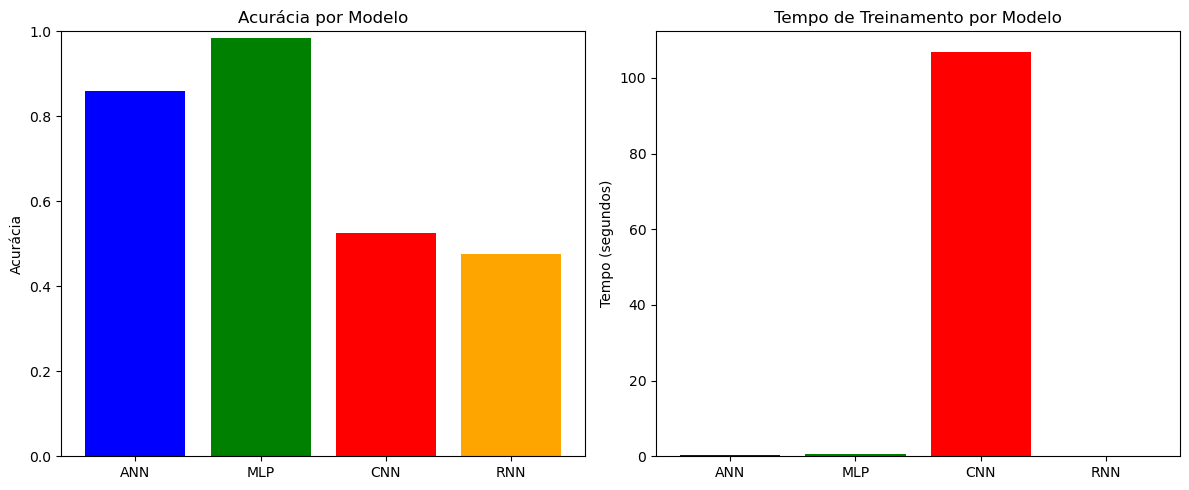


5. ANÁLISE COMPARATIVA
----------------------------------------

📊 CARACTERÍSTICAS DOS MODELOS:

• ANN (Artificial Neural Network):
  - Modelo mais simples
  - Boa para problemas básicos de classificação
  - Rápido para treinar

• MLP (Multi-Layer Perceptron):
  - Múltiplas camadas ocultas
  - Melhor capacidade de aproximação
  - Versátil para diversos problemas

• CNN (Convolutional Neural Network):
  - Especializada em dados com estrutura espacial
  - Excelente para imagens e sinais
  - Detecta padrões locais

• RNN (Recurrent Neural Network):
  - Processamento sequencial
  - Memória de estados anteriores
  - Boa para séries temporais

• GRU (Gated Recurrent Unit):
  - Versão melhorada do RNN
  - Resolve problema de gradiente explodindo
  - Mais eficiente que LSTM

• LSTM (Long Short-Term Memory):
  - Memória de longo prazo
  - Controle preciso de informações
  - Melhor para sequências longas

🎯 RECOMENDAÇÕES DE USO:

• Use ANN/MLP para:
  - Problemas de classificação simples
  - Da

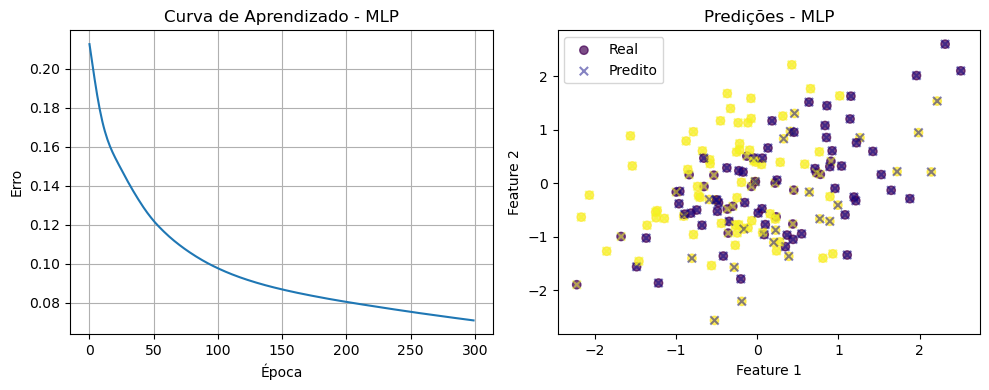


INSTRUÇÕES DE USO

1. Para comparar todos os modelos:
   compare_neural_networks()

2. Para testar modelo específico:
   X_train, X_test, y_train, y_test = create_custom_dataset('classification')
   test_specific_model('MLP', X_train, X_test, y_train, y_test)

3. Modelos disponíveis:
   - 'ANN': Rede Neural Artificial simples
   - 'MLP': Perceptron Multicamadas
   - 'CNN': Rede Neural Convolucional
   - 'RNN': Rede Neural Recorrente
   - 'GRU': Gated Recurrent Unit
   - 'LSTM': Long Short-Term Memory

4. Personalização:
   - Modifique os hiperparâmetros (learning_rate, epochs, etc.)
   - Ajuste as arquiteturas (número de camadas, neurônios)
   - Teste com seus próprios dados

💡 DICAS IMPORTANTES:
• Normalize sempre os dados antes do treinamento
• Monitore a curva de aprendizado para detectar overfitting
• Para dados reais, use validação cruzada
• Experimente diferentes funções de ativação
• Ajuste a taxa de aprendizado conforme necessário

🚀 PRÓXIMOS PASSOS:
• Implementar regularizaçã

In [13]:
if __name__ == "__main__":
    # Executar comparação completa
    compare_neural_networks()
    
    print("\n" + "="*80)
    print("EXEMPLO DE TESTE ESPECÍFICO")
    print("="*80)
    
    # Criar dados personalizados
    print("\nCriando dados personalizados...")
    X_train, X_test, y_train, y_test = create_custom_dataset('classification', 800)
    
    # Testar modelo específico
    test_specific_model('MLP', X_train, X_test, y_train, y_test, epochs=300)
    
    print("\n" + "="*80)
    print("INSTRUÇÕES DE USO")
    print("="*80)
    
    print("\n1. Para comparar todos os modelos:")
    print("   compare_neural_networks()")
    
    print("\n2. Para testar modelo específico:")
    print("   X_train, X_test, y_train, y_test = create_custom_dataset('classification')")
    print("   test_specific_model('MLP', X_train, X_test, y_train, y_test)")
    
    print("\n3. Modelos disponíveis:")
    print("   - 'ANN': Rede Neural Artificial simples")
    print("   - 'MLP': Perceptron Multicamadas")
    print("   - 'CNN': Rede Neural Convolucional")
    print("   - 'RNN': Rede Neural Recorrente")
    print("   - 'GRU': Gated Recurrent Unit")
    print("   - 'LSTM': Long Short-Term Memory")
    
    print("\n4. Personalização:")
    print("   - Modifique os hiperparâmetros (learning_rate, epochs, etc.)")
    print("   - Ajuste as arquiteturas (número de camadas, neurônios)")
    print("   - Teste com seus próprios dados")
    
    print("\n💡 DICAS IMPORTANTES:")
    print("• Normalize sempre os dados antes do treinamento")
    print("• Monitore a curva de aprendizado para detectar overfitting")
    print("• Para dados reais, use validação cruzada")
    print("• Experimente diferentes funções de ativação")
    print("• Ajuste a taxa de aprendizado conforme necessário")
    
    print("\n🚀 PRÓXIMOS PASSOS:")
    print("• Implementar regularização (dropout, L1/L2)")
    print("• Adicionar otimizadores mais avançados (Adam, RMSprop)")
    print("• Implementar early stopping")
    print("• Adicionar métricas mais robustas")
    print("• Testar com datasets reais (MNIST, CIFAR-10, etc.)")
    
    print("\n✨ SCRIPT FINALIZADO!")